<a href="https://colab.research.google.com/github/cosshoon/Anomaly-Detection-/blob/main/FFT(%EC%A0%84%EC%B2%98%EB%A6%AC)%2C_PCA%ED%99%9C%EC%9A%A9_Anomaly_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 데이터셋 불러오기

In [ ]:
from google.colab import drive
drive.mount('/g')

Drive already mounted at /g; to attempt to forcibly remount, call drive.mount("/g", force_remount=True).


In [ ]:
# Common imports
import os
import pandas as pd
import numpy as np
from sklearn import preprocessing
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline

from numpy.random import seed

from keras.layers import Input, Dropout
from keras.layers.core import Dense 
from keras.models import Model, Sequential, load_model
from keras import regularizers
from keras.models import model_from_json

In [ ]:
merged_database = pd.read_csv('/g/MyDrive/Machine Learning/SK fellowship/Dataset/IMS dataset/Averaged_BearingTest_Dataset_2nd.csv', index_col = 0)
merged_database.head()

,Bearing 1,Bearing 2,Bearing 3,Bearing 4
2004-02-12 10:32:39,0.058333,0.071832,0.083242,0.043067
2004-02-12 10:42:39,0.058995,0.074006,0.084435,0.044541
2004-02-12 10:52:39,0.060236,0.074227,0.083926,0.044443
2004-02-12 11:02:39,0.061455,0.073844,0.084457,0.045081
2004-02-12 11:12:39,0.061361,0.075609,0.082837,0.045118


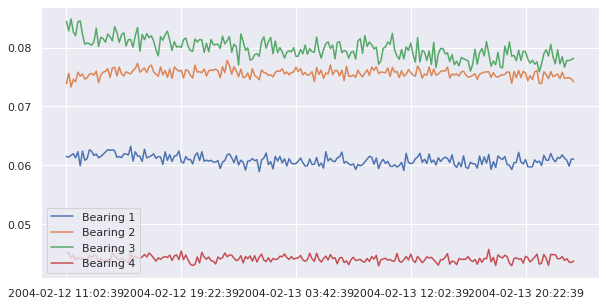

In [ ]:
train_dataset = merged_database['2004-02-12 11:02:39':'2004-02-13 23:52:39']
test_dataset = merged_database['2004-02-13 23:52:39' :]

train_dataset.plot(figsize = (10, 5))

In [ ]:
train_dataset.shape

(222, 4)

In [ ]:
train_dataset.index

Index(['2004-02-12 11:02:39', '2004-02-12 11:12:39', '2004-02-12 11:22:39',
       '2004-02-12 11:32:39', '2004-02-12 11:42:39', '2004-02-12 11:52:39',
       '2004-02-12 12:02:39', '2004-02-12 12:12:39', '2004-02-12 12:22:39',
       '2004-02-12 12:32:39',
       ...
       '2004-02-13 22:22:39', '2004-02-13 22:32:39', '2004-02-13 22:42:39',
       '2004-02-13 22:52:39', '2004-02-13 23:02:39', '2004-02-13 23:12:39',
       '2004-02-13 23:22:39', '2004-02-13 23:32:39', '2004-02-13 23:42:39',
       '2004-02-13 23:52:39'],
      dtype='object', length=222)

In [ ]:
train_fft = np.fft.fft(train_dataset)
test_fft = np.fft.fft(test_dataset)

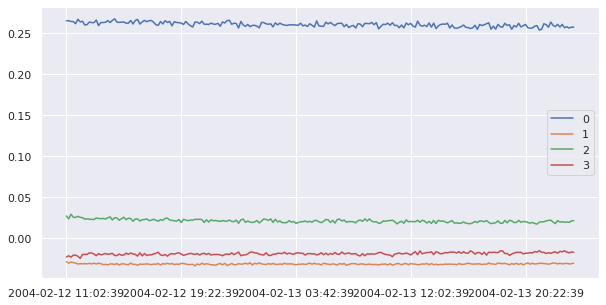

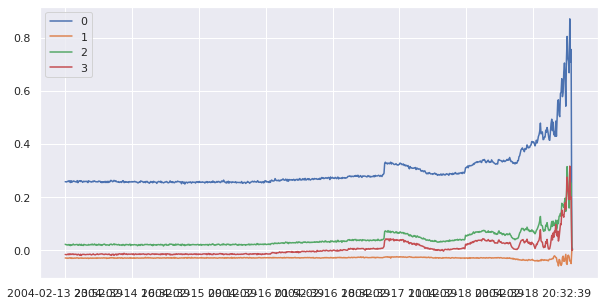

In [ ]:
train_fft_dataset = pd.DataFrame([train_fft[:,0].real, train_fft[:,1].imag, train_fft[:,2].real, train_fft[:,3].real])
train_fft_dataset = train_fft_dataset.transpose()
train_fft_dataset.index = train_dataset.index

train_fft_dataset.plot(figsize = (10, 5))



test_fft_dataset = pd.DataFrame([test_fft[:,0].real,test_fft[:,1].imag,test_fft[:,2].real, test_fft[:,3].real])
test_fft_dataset = test_fft_dataset.transpose()
test_fft_dataset.index = test_dataset.index

test_fft_dataset.plot(figsize = (10, 5))

In [ ]:
from sklearn.preprocessing import MinMaxScaler

def scaling_data(train_fft, test_fft):
    scaler = MinMaxScaler()
    X_train = pd.DataFrame(scaler.fit_transform(train_fft), 
                          columns=train_fft.columns,
                          index=train_fft.index)
    
    # Randomly shuffle training database
    X_train.sample(frac=1)
    
    X_test = pd.DataFrame(scaler.transform(test_fft), 
                          columns=test_fft.columns,
                          index=test_fft.index)
    return (X_train, X_test)

In [ ]:
X_train, X_test = scaling_data(train_fft_dataset, test_fft_dataset)

## PCA 알고리즘 적용

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, svd_solver= 'full')
X_train_PCA = pca.fit_transform(X_train)
X_train_PCA = pd.DataFrame(X_train_PCA)
X_train_PCA.index = X_train.index

X_test_PCA = pca.transform(X_test)
X_test_PCA = pd.DataFrame(X_test_PCA)
X_test_PCA.index = X_test.index

In [ ]:
def cov_matrix(data, verbose=False):
    covariance_matrix = np.cov(data, rowvar=False)
    if is_pos_def(covariance_matrix):
        inv_covariance_matrix = np.linalg.inv(covariance_matrix)
        if is_pos_def(inv_covariance_matrix):
            return covariance_matrix, inv_covariance_matrix
        else:
            print("Error: Inverse of Covariance Matrix is not positive definite!")
    else:
        print("Error: Covariance Matrix is not positive definite!")

In [ ]:
def MahalanobisDist(inv_cov_matrix, mean_distr, data, verbose=False):
    inv_covariance_matrix = inv_cov_matrix
    vars_mean = mean_distr
    diff = data - vars_mean
    md = []
    for i in range(len(diff)):
        md.append(np.sqrt(diff[i].dot(inv_covariance_matrix).dot(diff[i])))
    return md

In [ ]:
def MD_detectOutliers(dist, extreme=False, verbose=False):
    k = 3. if extreme else 2.
    threshold = np.mean(dist) * k
    outliers = []
    for i in range(len(dist)):
        if dist[i] >= threshold:
            outliers.append(i)  # index of the outlier
    return np.array(outliers)

In [ ]:
def MD_threshold(dist, extreme=False, verbose=False):
    k = 3. if extreme else 2.
    threshold = np.mean(dist) * k
    return threshold

In [ ]:
def is_pos_def(A):
    if np.allclose(A, A.T):
        try:
            np.linalg.cholesky(A)
            return True
        except np.linalg.LinAlgError:
            return False
    else:
        return False

In [ ]:
data_train = np.array(X_train_PCA.values)
data_test = np.array(X_test_PCA.values)

In [ ]:
cov_matrix, inv_cov_matrix  = cov_matrix(data_train)

In [ ]:
mean_distr = data_train.mean(axis=0)

In [ ]:
dist_test = MahalanobisDist(inv_cov_matrix, mean_distr, data_test, verbose=False)
dist_train = MahalanobisDist(inv_cov_matrix, mean_distr, data_train, verbose=False)
threshold = MD_threshold(dist_train, extreme = True)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(0.0, 15.0)

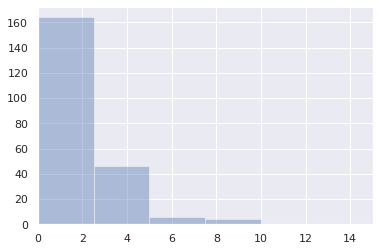

In [ ]:
plt.figure()
sns.distplot(np.square(dist_train),
             bins = 10, 
             kde= False);
plt.xlim([0.0,15])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Mahalanobis dist')

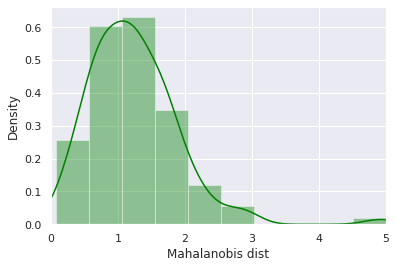

In [ ]:
plt.figure()
sns.distplot(dist_train,
             bins = 10, 
             kde= True, 
            color = 'green');
plt.xlim([0.0,5])
plt.xlabel('Mahalanobis dist')

In [ ]:
anomaly_train = pd.DataFrame()
anomaly_train['Mob dist']= dist_train
anomaly_train['Thresh'] = threshold
# If Mob dist above threshold: Flag as anomaly
anomaly_train['Anomaly'] = anomaly_train['Mob dist'] > anomaly_train['Thresh']
anomaly_train.index = X_train_PCA.index
anomaly = pd.DataFrame()
anomaly['Mob dist']= dist_test
anomaly['Thresh'] = threshold
# If Mob dist above threshold: Flag as anomaly
anomaly['Anomaly'] = anomaly['Mob dist'] > anomaly['Thresh']
anomaly.index = X_test_PCA.index
anomaly.head()

,Mob dist,Thresh,Anomaly
2004-02-13 23:52:39,1.836091,3.707443,False
2004-02-14 00:02:39,1.973361,3.707443,False
2004-02-14 00:12:39,1.336491,3.707443,False
2004-02-14 00:22:39,1.715056,3.707443,False
2004-02-14 00:32:39,1.282616,3.707443,False


In [ ]:
anomaly_alldata = pd.concat([anomaly_train, anomaly])
anomaly_alldata.to_csv('Anomaly_distance.csv')

In [ ]:
!ls

Anomaly_distance.csv  sample_data


(array([-200.,    0.,  200.,  400.,  600.,  800., 1000., 1200.]),
 <a list of 8 Text major ticklabel objects>)

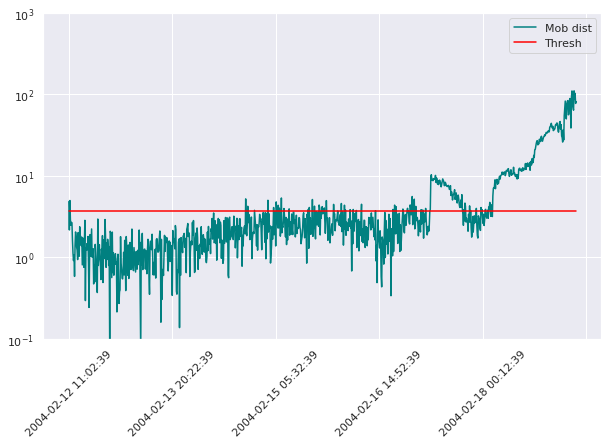

In [ ]:
anomaly_alldata.plot(logy=True, figsize = (10,6), ylim = [1e-1,1e3], color = ['teal','red'])
plt.xticks(rotation=45)